In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath('../'))
from utils.parse_data import load_trained_model
from interp_helpers import plot_attribution_all_targets
from feature_attribution import AttributionAnalyzer
import interp_helpers as interp
%load_ext autoreload
%autoreload 2

In [2]:
sns.set_theme(
    style='ticks',
    font_scale=1.0,
    rc={'axes.labelsize': 11,
        'axes.titlesize': 11,
        'savefig.transparent': True,
        'legend.title_fontsize': 11,
        'legend.fontsize': 10,
        'legend.borderpad': 0.2,
        'figure.titlesize': 11,
        'figure.subplot.wspace': 0.1,
        })

In [3]:
# Load the model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

run = 36 # fm.get_latest_run()
model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

Using cpu device


In [5]:
vocab = ['R', 'r', 'L', 'l']
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}
T = model_info['dataloader']['Sequence length (T)']

In [6]:
num_sequences = 300
events, sequences, counts = interp.get_common_sequences(T, run=run, k=num_sequences)

block_sequences  = interp.get_block_transition_sequences(events, T, high_port=1)
block_sequences = [list(b.values) for b in block_sequences]

In [22]:
analyzer = AttributionAnalyzer(model)
analyzer.layers

{'token_embedding': Embedding(4, 4), 'position_embedding': Embedding(6, 4)}

In [8]:
analyzer.model.transformer.named_modules

<bound method Module.named_modules of ModuleDict(
  (wte): Embedding(4, 4)
  (wpe): Embedding(6, 4)
  (h): ModuleList(
    (0): Block(
      (ln_1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (c_attn): Linear(in_features=4, out_features=12, bias=True)
        (c_proj): Linear(in_features=4, out_features=4, bias=True)
      )
      (ln_2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Linear(in_features=4, out_features=16, bias=True)
        (gelu): GELU(approximate='tanh')
        (c_proj): Linear(in_features=16, out_features=4, bias=True)
      )
    )
  )
  (ln_f): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
)>

In [9]:
sequences = interp.trim_leading_duplicates(block_sequences[10])
sequences

['LLLLLL',
 'LLLLLl',
 'LLLLll',
 'LLLllr',
 'LLllrR',
 'LllrRR',
 'llrRRR',
 'lrRRRR']

In [11]:
analyzer._get_module_by_path('transformer.h.0.attn')

CausalSelfAttention(
  (c_attn): Linear(in_features=4, out_features=12, bias=True)
  (c_proj): Linear(in_features=4, out_features=4, bias=True)
)

## Input-scaled/activation-scaled gradient attribution

For a sequence input:
$$
\begin{align}
[x_0, x_1, ..., x_T]
\end{align}
$$

that produces output logits $y$ (with dimensionality equal to vocabulary size), we compute:
$$
\begin{align}
x_0 (∂y/∂x_0) \\
x_1 (∂y/∂x_1) \\
... \\
x_T (∂y/∂x_T)
\end{align}
$$

$x_i$ are actually embedding vectors, not the token indices themselves. We compute the gradients of the logit for a particular target with respect to each input embedding, then multiply each embedding by its corresponding gradient.

We then generalize this approach to all layers of the model, such that attribution is defined as the gradient at the layer of interest for a particular target, scaled by the activation at that layer.

KeyboardInterrupt: 

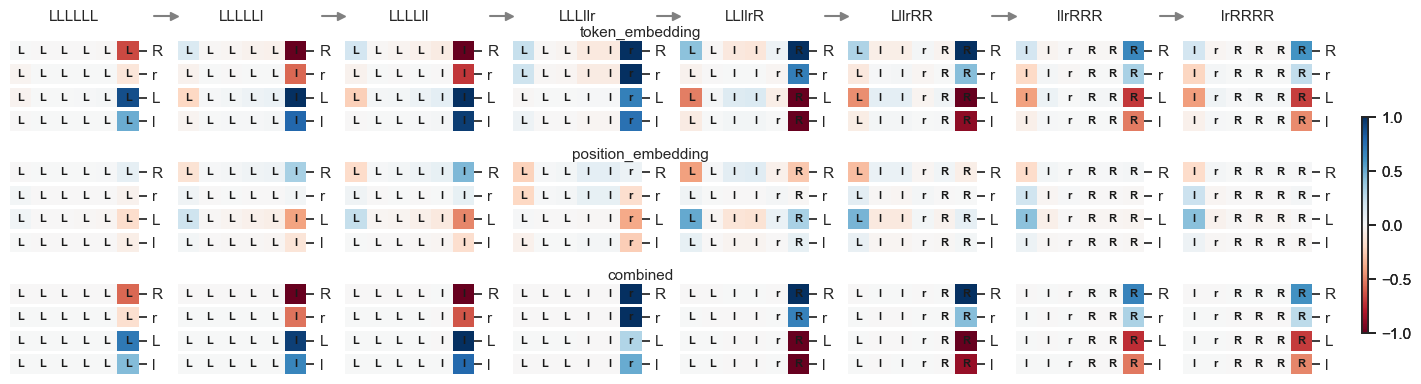

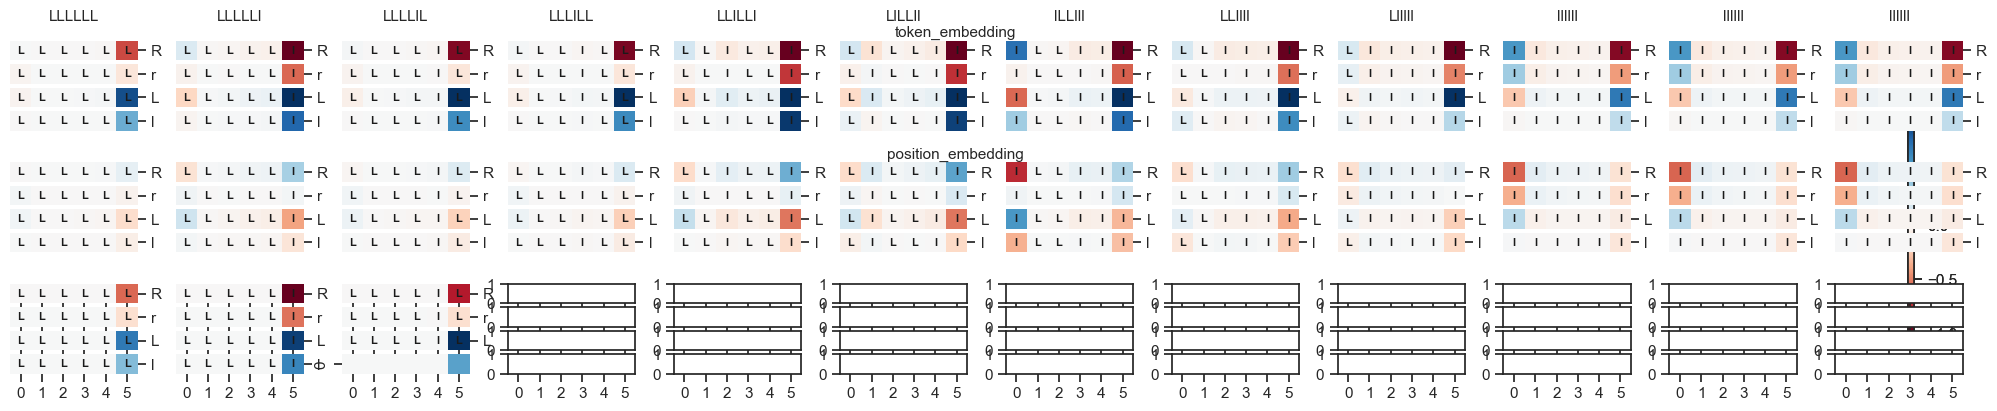

In [24]:
for seq in block_sequences[10:14]:
    seq_ = interp.trim_leading_duplicates(seq)
    fig, axs = analyzer.plot_attribution_contiguous_sequences(seq_, method='layer_gradient')

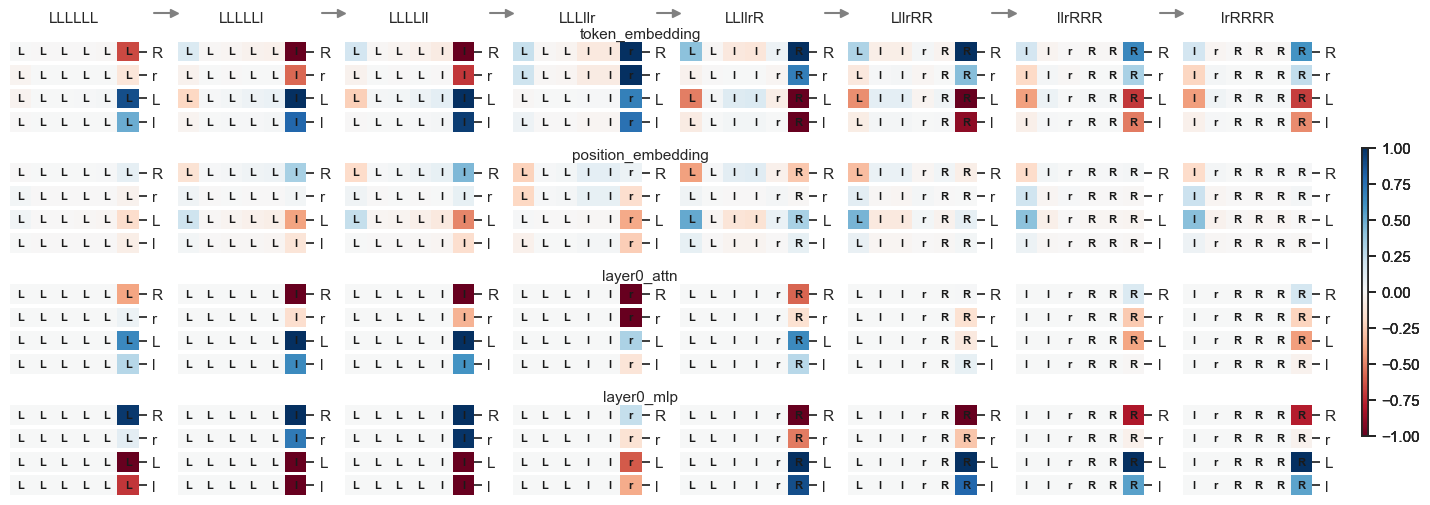

In [9]:
fig, axs = analyzer.plot_attribution_contiguous_sequences(sequences, method='layer_gradient')

token_embedding:
  Activation sign (mean): 0.000
  Gradient sign (mean): -0.083
position_embedding:
  Activation sign (mean): 0.083
  Gradient sign (mean): -0.083
layer0_attn_input:
  Activation sign (mean): 0.167
  Gradient sign (mean): -0.139
layer0_attn_output:
  Activation sign (mean): 0.000
  Gradient sign (mean): -0.083
layer0_ln1:
  Activation sign (mean): 0.000
  Gradient sign (mean): 0.500
layer0_mlp_input:
  Activation sign (mean): 0.500
  Gradient sign (mean): 0.125
layer0_mlp_output:
  Activation sign (mean): 0.000
  Gradient sign (mean): -0.083
token_embedding:
  Activation sign (mean): 0.000
  Gradient sign (mean): 0.000
position_embedding:
  Activation sign (mean): 0.083
  Gradient sign (mean): 0.000
layer0_attn_input:
  Activation sign (mean): 0.167
  Gradient sign (mean): -0.028
layer0_attn_output:
  Activation sign (mean): 0.000
  Gradient sign (mean): 0.000
layer0_ln1:
  Activation sign (mean): 0.000
  Gradient sign (mean): 0.000
layer0_mlp_input:
  Activation sign (

(<Figure size 210x960 with 40 Axes>,
 [array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)])

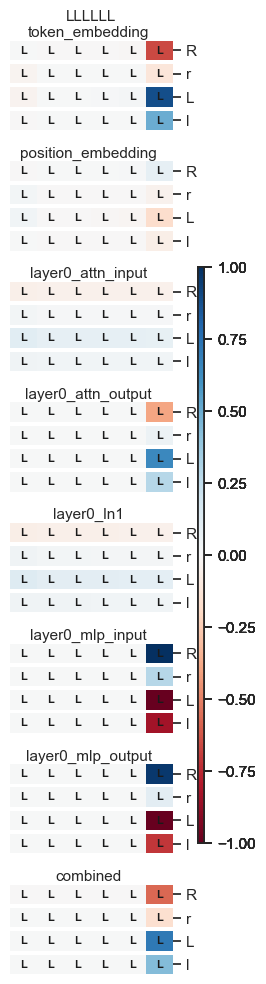

In [20]:
analyzer.plot_attribution_all_targets(sequences[0], method='layer_gradient')

(<Figure size 210x480 with 20 Axes>,
 [array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)])

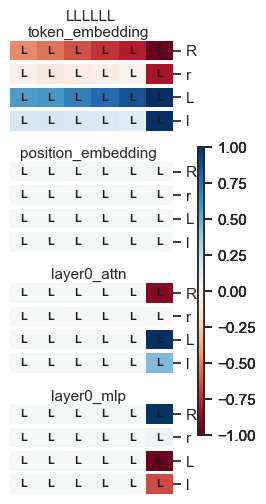

In [33]:
analyzer.plot_attribution_all_targets(sequences[0], method='integrated_gradients')

## Integrated gradients

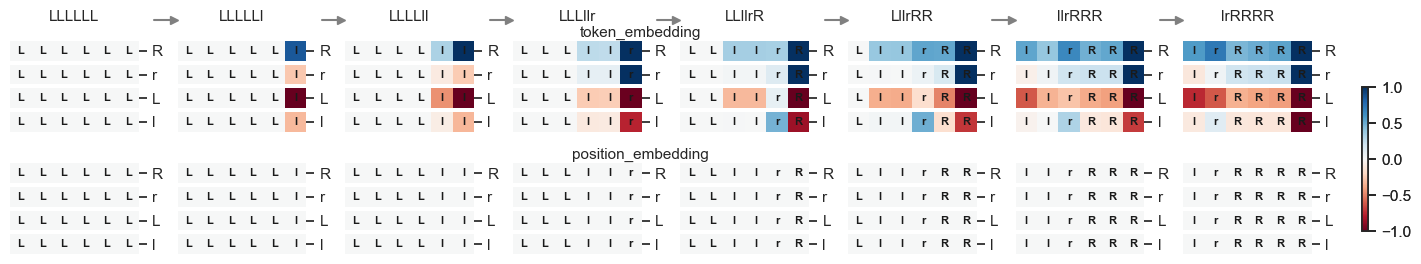

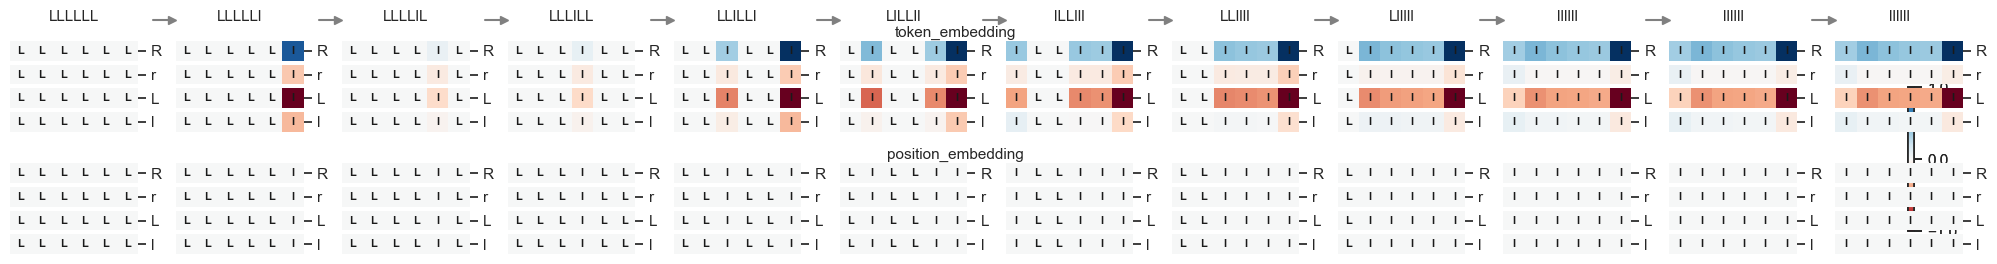

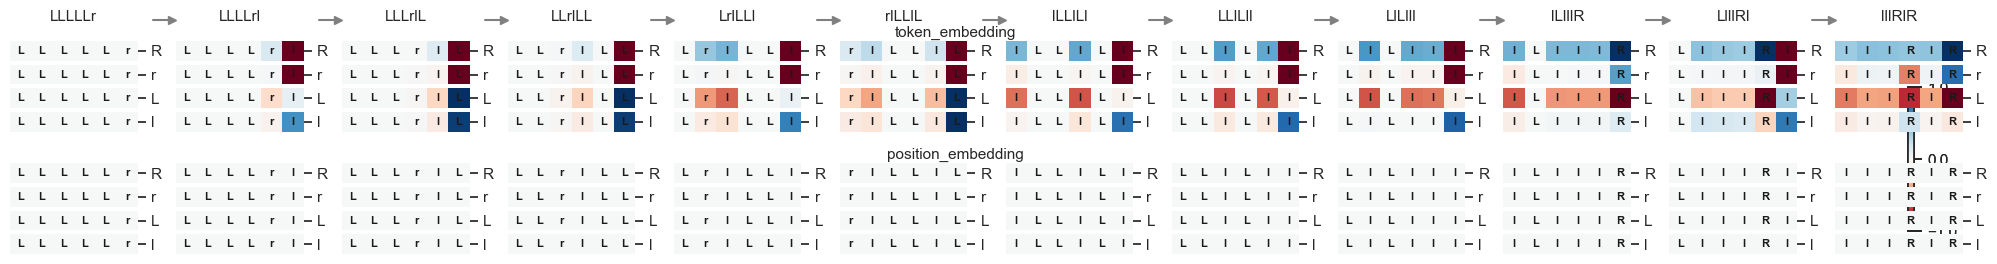

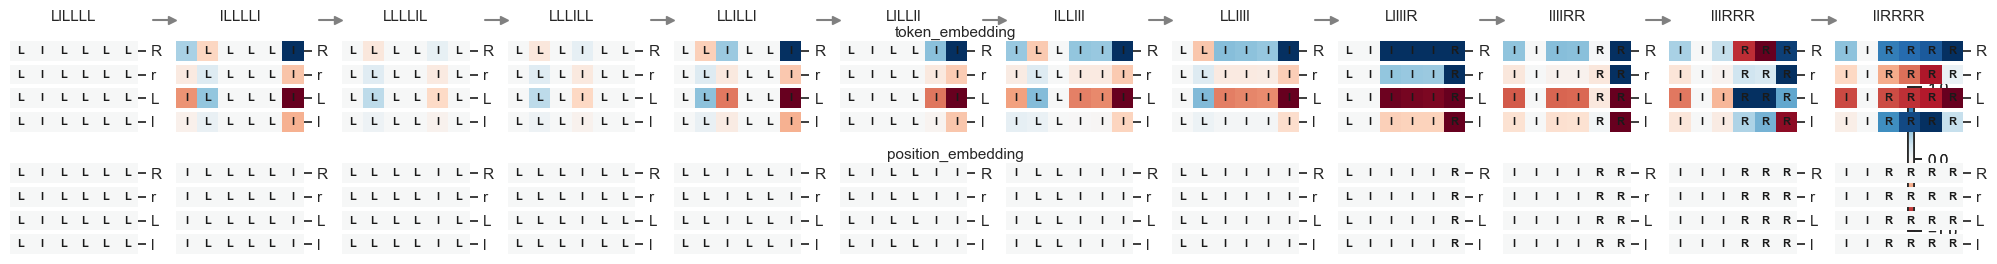

In [23]:
for seq in block_sequences[10:14]:
    seq_ = interp.trim_leading_duplicates(seq)
    fig, axs = analyzer.plot_attribution_contiguous_sequences(seq_, method='integrated_gradients', reference_sequence=seq_[0])

KeyboardInterrupt: 

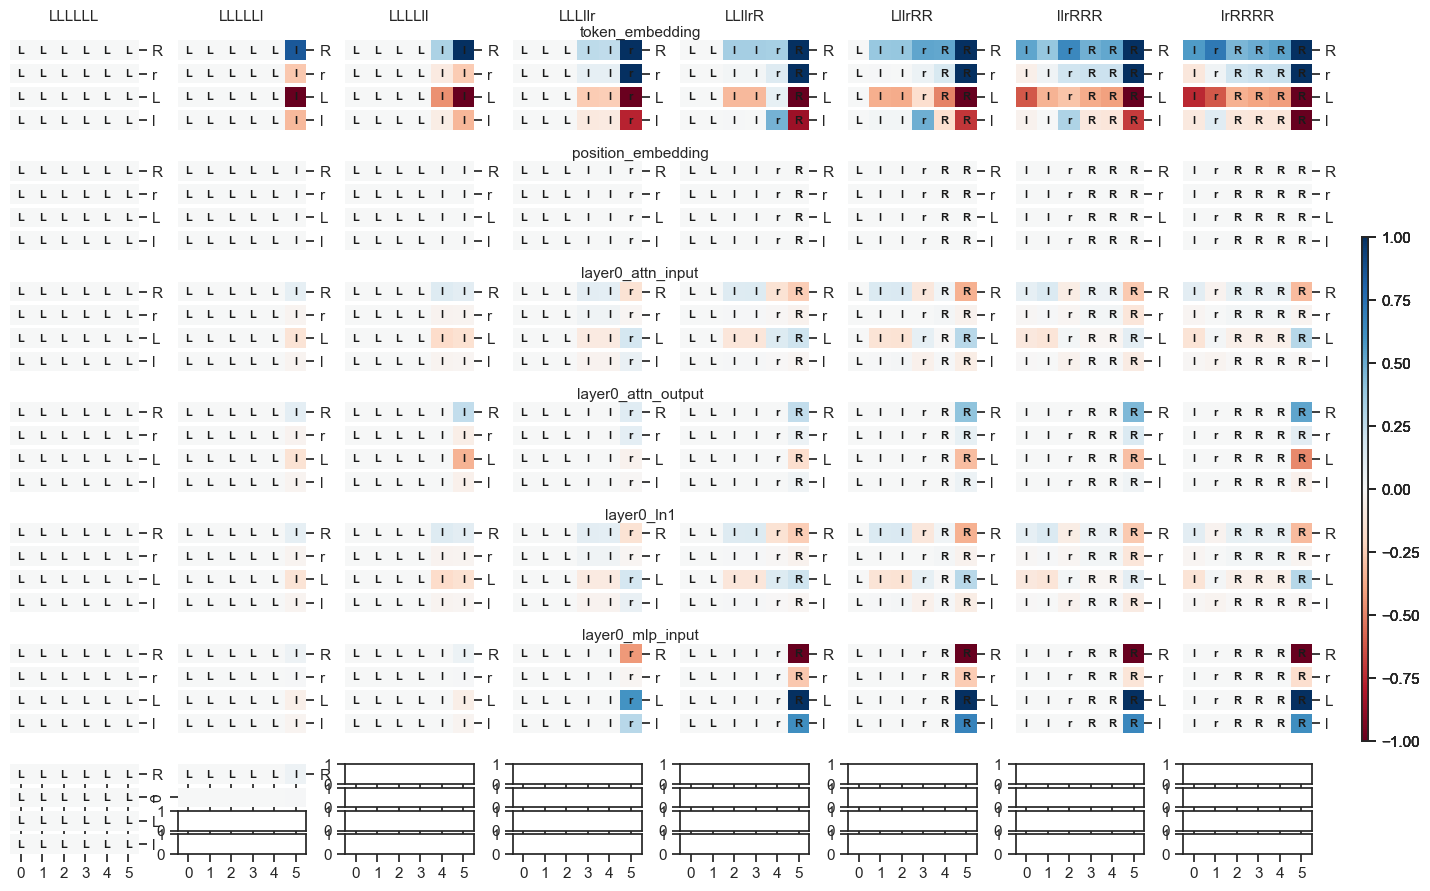

In [21]:
fig, axs = analyzer.plot_attribution_contiguous_sequences(sequences, method='integrated_gradients', reference_sequence='LLLLLL')


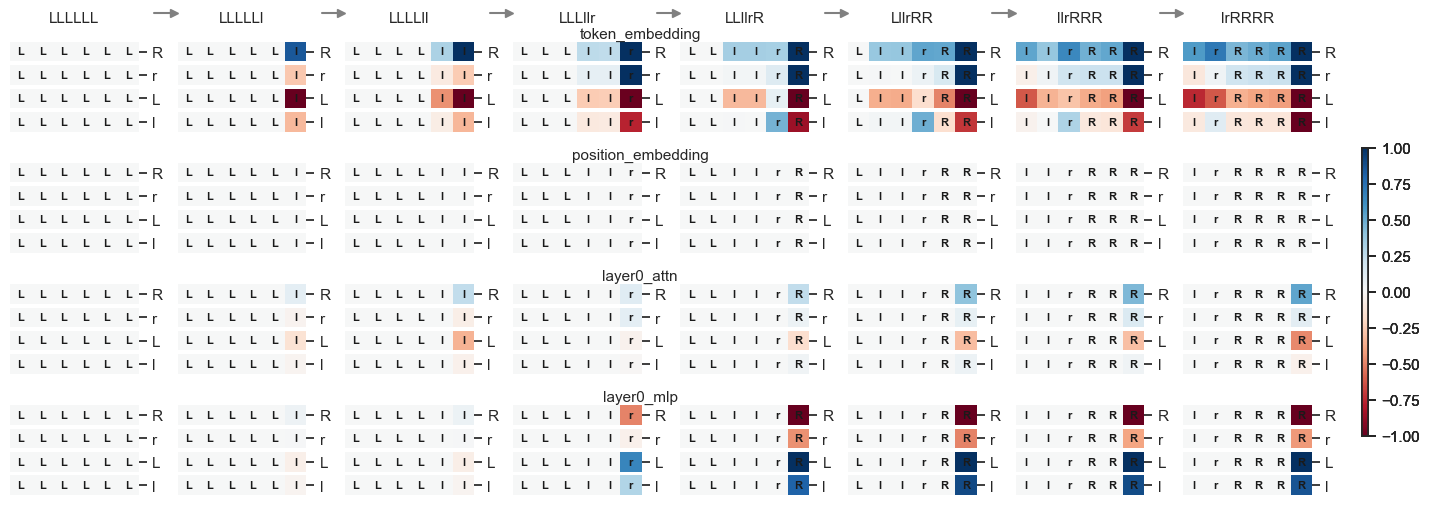

In [31]:
fig, axs = analyzer.plot_attribution_contiguous_sequences(sequences, method='integrated_gradients', reference_sequence='LLLLLL')

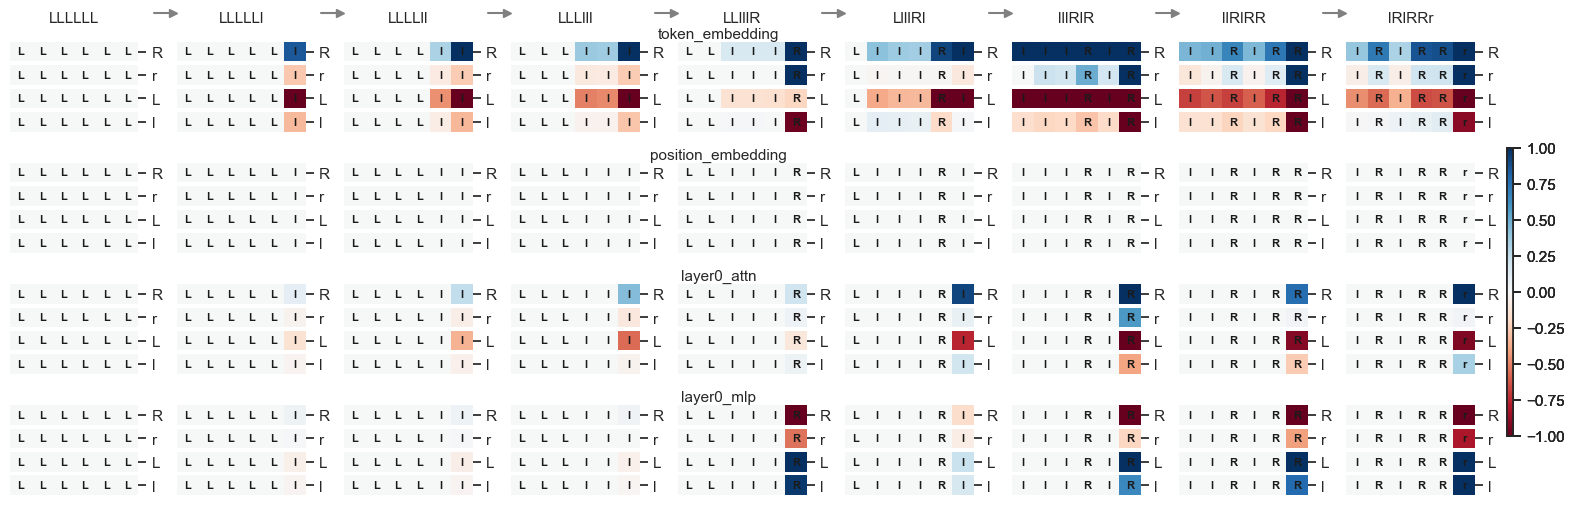

In [32]:
sequences = interp.trim_leading_duplicates(block_sequences[15].values.tolist())
fig, axs = analyzer.plot_attribution_contiguous_sequences(sequences, method='integrated_gradients', reference_sequence=sequences[0])

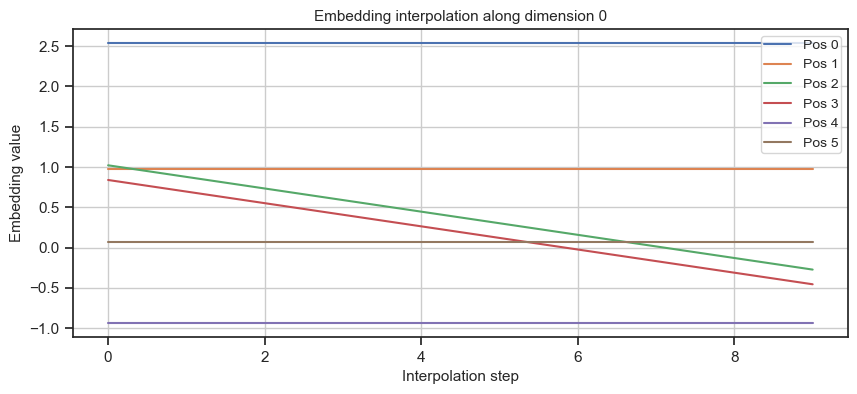

In [87]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 1. Set up vocab and mappings
vocab = ['A', 'B', 'C', 'D']
vocab_size = len(vocab)
token_to_id = {ch: i for i, ch in enumerate(vocab)}

# 2. Define model config
embedding_dim = 8
seq_length = 6

# 3. Token and positional embeddings
token_embed = nn.Embedding(vocab_size, embedding_dim)
position_embed = nn.Embedding(seq_length, embedding_dim)

# 4. Define inputs
input_tokens = ['A', 'A', 'B', 'B', 'A', 'A']      # target input
baseline_tokens = ['A', 'A', 'A', 'A', 'A', 'A']   # neutral baseline

input_ids = torch.tensor([token_to_id[tok] for tok in input_tokens])
baseline_ids = torch.tensor([token_to_id[tok] for tok in baseline_tokens])
positions = torch.arange(seq_length)

# 5. Get full embeddings (token + position)
def get_embeddings(token_ids):
    tok_embeds = token_embed(token_ids)
    pos_embeds = position_embed(positions)
    return tok_embeds + pos_embeds

input_embed = get_embeddings(input_ids)
baseline_embed = get_embeddings(baseline_ids)

# 6. Interpolate between baseline and input (IG path)
def interpolate_embeddings(baseline, input, steps=10):
    alphas = torch.linspace(0, 1, steps).view(steps, 1, 1)  # shape (steps, 1, 1)
    return baseline + alphas * (input - baseline)  # shape (steps, seq_len, emb_dim)

interpolated_embeds = interpolate_embeddings(baseline_embed, input_embed, steps=10)

# 7. Visualize one embedding dimension across sequence and steps
def plot_interpolation(interpolated, dim=0):
    # interpolated: (steps, seq_len, emb_dim)
    plt.figure(figsize=(10, 4))
    for i in range(seq_length):
        plt.plot(range(interpolated.shape[0]), interpolated[:, i, dim].detach().numpy(), label=f"Pos {i}")
    plt.title(f"Embedding interpolation along dimension {dim}")
    plt.xlabel("Interpolation step")
    plt.ylabel("Embedding value")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_interpolation(interpolated_embeds, dim=0)


In [84]:
joint_probs

tensor([[[0.3669, 0.1572],
         [0.1903, 0.2855]]], grad_fn=<MulBackward0>)

### Manual gradient calculation

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F

n_samples = 1
n_features = 3
n_rewards = 2

# Dummy data
X = torch.randn(n_samples, n_features)
true_choice = torch.randint(0, 2, (n_samples,))      # 0 or 1
true_reward = torch.randint(0, n_rewards, (n_samples,))  # 0 or 1

# Construct joint class labels (choice * n_rewards + reward)
joint_targets = true_choice * n_rewards + true_reward  # class index in [0, 3]

# ---- 2. Binary Logistic Regression Model ---- #
class BinaryChoiceModel(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)  # one logit output

    def forward(self, x):
        logits = self.linear(x).squeeze(-1)  # shape: (batch,)
        p_choice = torch.sigmoid(logits)     # shape: (batch,)
        return p_choice

model = BinaryChoiceModel(n_features)

# ---- 3. Fixed reward filter: p(r | c) ---- #
# Shape: (2 choices, 2 rewards)
P_r_given_c = torch.tensor([
    [0.8, 0.2],  # reward given choice 0
    [0.2, 0.8]   # reward given choice 1
], dtype=torch.float32)

# ---- 4. Forward pass ---- #
p_choice = model(X)  # shape: (n_samples,)

# Convert to 2-column tensor: p(c=0), p(c=1)
p_choice_mat = torch.stack([1 - p_choice, p_choice], dim=1)  # shape: (n_samples, 2)

# Compute joint p(choice, reward)
# Shape: (n_samples, 2 choices, 2 rewards)
joint_probs = p_choice_mat.unsqueeze(2) * P_r_given_c.unsqueeze(0)

# Flatten to shape (n_samples, 4 classes)
joint_probs_flat = joint_probs.view(n_samples, -1)

# ---- 5. Cross-entropy loss ---- #
log_preds = torch.log(joint_probs_flat + 1e-8)  # avoid log(0)
loss = F.nll_loss(log_preds, joint_targets)

print("Loss:", loss.item())

model.zero_grad()
loss.backward()

Loss: 2.476320743560791
